# Overview

Add our overview narrative here!!!!


In [24]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

## Encoder

This Encoder class is a part of the larger sequence-to-sequence model designed for processing mathematical word problems using an LSTM. It takes input sequences (math question) represented as token indices and converts them into dense vector embeddings using an embedding layer, allowing the model to capture meaningful semantic relationships between words. The embedded representations then pass through an LSTM layer, which extracts temporal dependencies and generates both hidden and cell states that encode contextual information about the input sequence. A dropout layer is applied to the embeddings to reduce overfitting and improve generalization. Ultimately, the encoder produces a set of outputs from each time step and a final hidden representation, which the decoder later uses to generate responses or solutions (the expected answer to our math question).

In [25]:
class Encoder(nn.Module):
    """ 
    Encoder for the sequence-to-sequence math problem assistant model using an LSTM. 
    Converts a sequence of token indices into a hidden representation 
    that will be used by the decoder for sequence generation.
    """
    def __init__(self, input_size, hidden_size, dropout=0.1):
        """
        Initializes the Encoder module.

        Args:
            input_size (int): The size of the input vocabulary.
            hidden_size (int): The number of hidden units in the LSTM.
            dropout (float): Dropout rate to prevent overfitting.
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer converts token indices into dense vector representations.
        # Instead of using raw word indices (which lack meaning), embeddings allow
        # the LSTM to learn meaningful semantic relationships between words.
        self.embedding = nn.Embedding(input_size, hidden_size)

        # LSTM layer processes embedded input sequences to generate hidden states.
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        # Dropout layer applied to embeddings to prevent overfitting.
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        """
        Forward pass through the encoder.

        Args:
            input_seq (Tensor): Tensor containing token indices for a batch of input sentences.

        Returns:
            outputs (Tensor): Encoder outputs at each time step.
            hidden (Tensor): Final hidden state of the LSTM.
            cell (Tensor): Final cell state of the LSTM.
        """
        embedded = self.embedding(input_seq)           # Convert input tokens into embeddings
        embedded = self.dropout(embedded)             # Apply dropout before LSTM processing
        outputs, (hidden, cell) = self.lstm(embedded) # Process embeddings through LSTM

        return outputs, (hidden, cell)

## Attention

The Attention class implements 'Bahdanau attention', which dynamically calculates attention scores based on the decoder’s hidden state and the encoder’s outputs. Instead of relying on a fixed context vector, this method allows the decoder to focus on specific parts of the input sequence at each decoding step. The attention mechanism works by concatenating the decoder's hidden state with the encoder’s outputs, passing them through a linear transformation, and applying the tanh activation function. A learnable vector (v) helps compute alignment scores, which are then normalized using softmax to generate attention weights—these determine the importance of each encoder output when predicting the next token. A dropout layer is also applied to prevent overfitting. The output is a set of attention weights that guides the decoder in generating more context-aware responses.

In [26]:
class Attention(nn.Module):
    """ 
    Implements Bahdanau attention mechanism for a sequence-to-sequence model. 
    Dynamically computes attention scores based on the decoder’s hidden state 
    and the encoder’s outputs, allowing the decoder to focus on relevant 
    parts of the input sequence at each decoding step.
    """
    def __init__(self, hidden_size, dropout=0.1):
        """
        Initializes the attention mechanism.

        Args:
            hidden_size (int): The size of the hidden state of the LSTM.
            dropout (float): Dropout rate to prevent overfitting.
        """
        super(Attention, self).__init__()

        # Linear layer to compute alignment scores
        self.attn = nn.Linear(hidden_size * 2, hidden_size)

        # Learnable vector for attention computation
        self.v = nn.Parameter(torch.rand(hidden_size))

        # Dropout layer to regularize attention mechanism and prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, hidden, encoder_outputs):
        """
        Computes attention weights using Bahdanau's additive attention method.

        Args:
            hidden (Tensor): Decoder hidden state at the current time step.
            encoder_outputs (Tensor): Encoder outputs at all time steps.

        Returns:
            attention_weights (Tensor): Softmax-normalized attention scores.
        """
        seq_len = encoder_outputs.size(1)

        # Expand the decoder hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)

        # Concatenate hidden state with encoder outputs to compute alignment scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        # Apply dropout to energy scores before computing attention weights
        energy = self.dropout(energy)

        # Transpose energy tensor for compatibility with the attention vector
        energy = energy.permute(0, 2, 1)

        # Expand learned vector `v` across batch size
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)

        # Compute attention weights via matrix multiplication
        attention_weights = torch.bmm(v, energy).squeeze(1)

        # Apply softmax to normalize scores across sequence length
        return torch.softmax(attention_weights, dim=1)

## Decoder

The Decoder class plays a crucial role in our sequence-to-sequence model designed to solve math word problems. When given a problem as an input sequence, the Encoder first processes it into a hidden representation, which the Decoder then uses to generate the solution step by step. At each step, the attention mechanism dynamically selects the most relevant parts of the encoded problem statement, allowing the Decoder to focus on specific numerical relationships and mathematical operations. The LSTM maintains contextual understanding across time steps, helping track dependencies between numbers and mathematical operators. As the model generates each token in the solution, it refines its prediction using previously computed values, making the process similar to how humans break down word problems into logical steps. This structure ensures that the model interprets and solves math problems contextually, rather than simply memorizing formulas, enabling it to generalize across different problem types.

In [27]:
class Decoder(nn.Module):
    """ 
    Decoder for the sequence-to-sequence math problem assistant model using an 
    LSTM with Bahdanau attention. The decoder generates output tokens one by one 
    while dynamically focusing on relevant parts of the encoder’s outputs using 
    the attention mechanism.
    """
    def __init__(self, output_size, hidden_size, dropout=0.1):
        """
        Initializes the Decoder module.

        Args:
            output_size (int): The size of the output vocabulary.
            hidden_size (int): The number of hidden units in the LSTM.
            dropout (float): Dropout rate to prevent overfitting.
        """
        super(Decoder, self).__init__()

        # Embedding layer converts token indices into dense vectors
        self.embedding = nn.Embedding(output_size, hidden_size)

        # LSTM layer processes embeddings and maintains hidden state across timesteps
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        # Linear layer maps concatenated attention context & LSTM output to vocab space
        self.fc = nn.Linear(hidden_size * 2, output_size)

        # Dropout layer to regularize embeddings before passing them to LSTM
        self.dropout = nn.Dropout(dropout)  

        # Attention mechanism for dynamic focus on encoder outputs
        self.attention = Attention(hidden_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        """
        Forward pass for the decoder.

        Args:
            input (Tensor): Current token input to the decoder.
            hidden (Tensor): Previous hidden state from the LSTM.
            cell (Tensor): Previous cell state from the LSTM.
            encoder_outputs (Tensor): Encoder outputs from all timesteps.

        Returns:
            output (Tensor): Predicted token probabilities.
            hidden (Tensor): Updated hidden state.
            cell (Tensor): Updated cell state.
            attention_weights (Tensor): Attention scores for each encoder timestep.
        """
        # Expand input dimensions to match expected input shape for embedding
        input = input.unsqueeze(1)  

        # Convert token indices into dense embeddings & apply dropout for regularization
        embedded = self.dropout(self.embedding(input))

        # Forward pass through LSTM to generate new hidden and cell states
        lstm_output, (hidden, cell) = self.lstm(embedded, (hidden, cell))

        # Compute attention weights using the current hidden state and encoder outputs
        attention_weights = self.attention(hidden[-1], encoder_outputs)

        # Apply attention: generate weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)

        # Flatten tensors for the fully connected layer
        lstm_output = lstm_output.squeeze(1)
        context = context.squeeze(1)

        # Generate token probabilities using concatenated LSTM output and attention context
        output = self.fc(torch.cat((lstm_output, context), dim=1))

        return output, hidden, cell, attention_weights

##  Basic tokenisation and vocabulary Setup

Here we set up the constants and tokenisation process for a sequence-to-sequence math problem assistant. It first defines special tokens <SOS>, <EOS>, and <PAD> to mark the start, end, and padding of sequences. Then, it creates a vocabulary mapping that converts words into numerical indices, allowing the model to process text as numbers. The reverse mapping (index_to_word) ensures that predictions can be decoded back into words. Finally, the script tokenizes example input and target sequences, transforming for example, "two plus four" into a list of indices [3, 4, 5] and the target "equals six" into [0, 6, 7, 1], ensuring that the decoder starts with <SOS> and ends with <EOS>. This setup enables the neural network to work with structured input-output pairs for training our expected math-solving model.

In [28]:
#Estalish constants
START_OF_SEQUENCE = "<SOS>"
END_OF_SEQUENCE = "<EOS>"
PADDING_SEQUENCE = "<PAD>"

# Tokenization and vocab setup
# Create a vocabulary mapping words to indices
word_to_index = {START_OF_SEQUENCE: 0, END_OF_SEQUENCE: 1, PADDING_SEQUENCE: 2, "two": 3, "plus": 4, "four": 5, "equals": 6, "six": 7, "three": 8, "minus": 9, "one": 10}
index_to_word = {v: k for k, v in word_to_index.items()}  # Reverse mapping for decoding

# Example input and target sequences
input_sentence = "two plus four"
target_sentence = "equals six"

# Test Tokenized input and targets
input_tokens = [word_to_index[word] for word in input_sentence.split()]
target_tokens = [word_to_index[START_OF_SEQUENCE]] + [word_to_index[word] for word in target_sentence.split()] + [word_to_index[END_OF_SEQUENCE]]

## Generate the math problem dataset from the tokenzied data

This BasicMathWordProblemDataset class creates a custom PyTorch Dataset for training our sequence-to-sequence model that solves basic math word problems. It converts input and target sentences (our math questions) into lists of token indices using a predefined vocabulary (word_to_index). The target sequence is prepended with <SOS> and appended with <EOS> tokens to indicate the start and end of the output. The class implements essential dataset methods, notablu __len__() which returns the number of samples, while __getItem__() retrieves tokenized tensors for input and target sequences, ensuring compatibility with PyTorch models. Finally, the dataset is wrapped in a DataLoader, allowing efficient batch processing with shuffling to improve learning dynamics.

In [29]:
from torch.utils.data import Dataset

class BasicMathWordProblemDataset(Dataset):
    def __init__(self, input_sentences, target_sentences, word_to_index):
        self.input_data = [[word_to_index[word] for word in sentence.split()] for sentence in input_sentences]
        self.target_data = [[word_to_index[START_OF_SEQUENCE]] +
                            [word_to_index[word] for word in sentence.split()] +
                            [word_to_index[END_OF_SEQUENCE]] for sentence in target_sentences]

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return torch.tensor(self.input_data[idx], dtype=torch.long), torch.tensor(self.target_data[idx], dtype=torch.long)

# Example data
input_sentences = ["two plus four"]
target_sentences = ["equals six"]

# Create dataset and dataloader
dataset = BasicMathWordProblemDataset(input_sentences, target_sentences, word_to_index)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

## Establish hyperparamters

Here we initialise the key components for training our sequence-to-sequence math word problem solving model. The encoder and decoder are instantiated with the vocabulary size (input_size and output_size) and a hidden state of 128, allowing the model to process and generate our math solutions. The CrossEntropy loss function is used with padding tokens ignored to prevent unnecessary calculations from affecting training. Adam optimizers are applied to both the encoder and decoder with a learning rate of 0.001, enabling stable gradient updates. Finally, an attention matrix is initialized to store attention weights, which will later be used for visualization, thus helping to analyze how the model focuses on different parts of the input when generating solutions.

In [30]:
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the encoder and decoder
input_size = len(word_to_index)  # Total vocabulary size
output_size = len(word_to_index)  # Vocabulary size
hidden_size = 128

encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(output_size, hidden_size).to(device)

# Ignore padding tokens
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE])  
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

# Store attention weights for visualization
attention_matrix = []  

## Plot training loss over epochs

This function visualizes the training loss over epochs using Matplotlib. It takes a list of loss values (epoch_losses), representing the loss at each epoch, and plots them on a graph to track performance trends over time. This is useful for monitoring model convergence and diagnosing potential issues such as overfitting or slow learning.

In [31]:
import matplotlib.pyplot as plt

def plot_loss(epoch_losses):
    """Plots the training loss over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

## Establish the training regime

This train() function is responsible for training our sequence-to-sequence model with an encoder-decoder architecture with 'Bahdanau attention'. It iterates through a dataset of tokenized math problems for multiple epochs, processing each batch by passing inputs through the encoder, which generates a context vector. The decoder then predicts output tokens step by step, using teacher forcing to guide learning while dynamically focusing on relevant parts of the input via attention mechanisms. The function tracks masked loss, ensuring that padding tokens don't affect optimization, and updates model weights using backpropagation with Adam optimizers. After training, it stores attention weights for visualization, logs epoch losses, plots them for monitoring, and saves the trained models to disk.

In [32]:
def train(num_epochs, encoder_save_name, decoder_save_name):
    """
    Trains the sequence-to-sequence model using an encoder-decoder architecture.

    Args:
        num_epochs (int): Number of training epochs.
        encoder_save_name (str): File name for saving the trained encoder model.
        decoder_save_name (str): File name for saving the trained decoder model.
    """
    epoch_losses = []  # Stores loss values for tracking progress

    for epoch in range(num_epochs):
        epoch_loss = 0  # Accumulate total loss for the epoch

        for input_seq, target_seq in dataloader:
            # Move data to GPU if available
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)

            # Reset gradients before each batch
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # Encoder forward pass - processes input sequences to generate hidden states
            encoder_outputs, (hidden, cell) = encoder(input_seq)

            # Decoder initialization - starts with the encoder's final hidden state
            decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell

            # Get actual sequence lengths (excluding padding)
            target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE]).sum(dim=1)
            max_target_length = target_lengths.max().item()

            loss = 0  # Tracks batch loss
            
            # Iterate through target sequence timesteps
            for t in range(max_target_length):
                # Determine active sequences
                still_active = t < target_lengths
                if not still_active.any():  # If all sequences finished, break loop
                    break

                # Decoder forward pass - generates output token probabilities
                output, decoder_hidden, decoder_cell, attention_weights = decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                )

                # Masked loss calculation - only consider active sequences
                loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum() / still_active.sum()

                # Teacher forcing: Use actual target token as next input
                decoder_input = target_seq[:, t]  

            # Backpropagation - compute gradients and update model parameters
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()

            epoch_loss += loss.item()

        # Store normalized loss
        epoch_losses.append(epoch_loss / len(dataloader))

        # Print training progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_losses[-1]:.4f}")

        # Store attention weights for visualization
        attention_matrix.append(attention_weights.cpu().detach().numpy())

    # Plot training loss
    plot_loss(epoch_losses)

    # Save the trained models
    torch.save(encoder.state_dict(), f"{encoder_save_name}.pth")
    torch.save(decoder.state_dict(), f"{decoder_save_name}.pth")

## Train the model

We'll start training for 100 epochs to refine our sequence-to-sequence model. This will help our encoder-decoder system learn better representations and improve predictions for solving math word problems. We'll expect to see loss decreasing over time, but if it stagnates or spikes, we can adjust learning rate, batch size, and/or other hyperparameters to stabilise training. Also, our ability to monitor attention weights will help us verify whether the model is correctly focusing on key parts of the input during decoding.

Epoch 1/100, Loss: 9.6464
Epoch 2/100, Loss: 8.9517
Epoch 3/100, Loss: 8.1775
Epoch 4/100, Loss: 7.5406
Epoch 5/100, Loss: 6.8955
Epoch 6/100, Loss: 6.3454
Epoch 7/100, Loss: 5.7458
Epoch 8/100, Loss: 5.1202
Epoch 9/100, Loss: 4.6462
Epoch 10/100, Loss: 4.1824
Epoch 11/100, Loss: 3.7260
Epoch 12/100, Loss: 3.4011
Epoch 13/100, Loss: 2.9852
Epoch 14/100, Loss: 2.7587
Epoch 15/100, Loss: 2.3901
Epoch 16/100, Loss: 2.1689
Epoch 17/100, Loss: 1.9994
Epoch 18/100, Loss: 1.7870
Epoch 19/100, Loss: 1.6325
Epoch 20/100, Loss: 1.4670
Epoch 21/100, Loss: 1.3234
Epoch 22/100, Loss: 1.1725
Epoch 23/100, Loss: 1.0869
Epoch 24/100, Loss: 0.9704
Epoch 25/100, Loss: 0.8914
Epoch 26/100, Loss: 0.8354
Epoch 27/100, Loss: 0.7640
Epoch 28/100, Loss: 0.6730
Epoch 29/100, Loss: 0.6229
Epoch 30/100, Loss: 0.5628
Epoch 31/100, Loss: 0.5154
Epoch 32/100, Loss: 0.4701
Epoch 33/100, Loss: 0.4334
Epoch 34/100, Loss: 0.4027
Epoch 35/100, Loss: 0.3665
Epoch 36/100, Loss: 0.3317
Epoch 37/100, Loss: 0.3092
Epoch 38/1

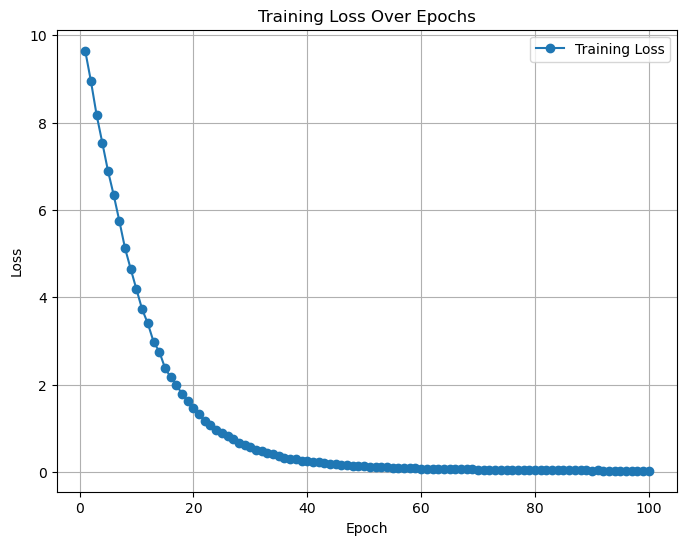

In [33]:
num_epochs = 100  # Define the number of epochs
train(num_epochs, "basic_math_problem_encoder", "basic_math_problem_decoder")

## Generate heatmap

Function to allow us to visualise attention weights as a heatmap, helping us analyse which input tokens the decoder focuses on while generating each output token in a sequence-to-sequence model. Using Matplotlib, it plots the attention_matrix as a color-coded intensity map, where darker shades indicate stronger attention at specific positions. This visualization is helpful for allowing us to understand how our model prioritises different parts of the input, making it inciteful when attempting to optimise our attention mechanism. 

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(input_tokens, output_tokens, attention_matrix):
    """
    Plot the attention weights as a heatmap.

    Args:
        input_tokens (list of str): Tokens in the input sequence.
        output_tokens (list of str): Tokens in the output sequence.
        attention_matrix (np.array): Attention weights matrix (output_tokens x input_tokens).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, cmap="viridis", interpolation="nearest")
    plt.xticks(ticks=np.arange(len(input_tokens)), labels=input_tokens, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(output_tokens)), labels=output_tokens)
    plt.colorbar(label="Attention Weight")
    plt.xlabel("Input Tokens")
    plt.ylabel("Output Tokens")
    plt.title("Attention Heatmap")
    plt.tight_layout()
    plt.show()

## Test setup

Function to allow us to test our trained sequence-to-sequence model by encoding our math question input sentence into hidden states and decoding it step-by-step to generate our expected answer. It tokenizes the input using a predefined vocabulary and passes it through the encoder, which extracts a contextual representation. The decoder then predicts each output token using an iterative approach, incorporating attention weights to dynamically focus on relevant parts of the input. The function tracks attention matrices, enabling visualization of how the model distributes focus across tokens. It prints the input sentence, generated output, and attention shape, and optionally plots a heatmap for deeper analysis. The final output is a list of predicted words, representing the answer to our math problem, which can then be evaluated for accuracy.

In [35]:
def test(encoder, decoder, input_sentence, word_to_index, index_to_word, max_target_length=100, with_attention_plot=False):
    # Set the models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Tokenize the input sentence
    input_tokens = [word_to_index[word] for word in input_sentence.split()]
    input_seq = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension

    # Forward pass through the encoder
    encoder_outputs, (hidden, cell) = encoder(input_seq)

    # Initialize the decoder
    decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]], dtype=torch.long)  # Start-of-Sequence token
    decoder_hidden = hidden
    decoder_cell = cell

    # Generate output sequence and collect attention weights
    output_sequence = []
    attention_matrices = []

    for _ in range(max_target_length):
        output, decoder_hidden, decoder_cell, attention_weights = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs
        )
        predicted_token = output.argmax(1).item()  # Get the token with the highest probability

        if predicted_token == word_to_index[END_OF_SEQUENCE]:  # Stop at End-of-Sequence token
            break

        output_sequence.append(predicted_token)
        attention_matrices.append(attention_weights.cpu().detach().numpy())  # Save attention weights

        decoder_input = torch.tensor([predicted_token], dtype=torch.long)  # Next decoder input

    # Convert input and output tokens to words
    input_sentence_tokens = [index_to_word[token] for token in input_tokens]
    output_sentence_tokens = [index_to_word[token] for token in output_sequence]

    # Stack attention matrices into a 2D array (output_tokens x input_tokens)
    attention_matrix = np.vstack(attention_matrices)

    # Print the input and output sentences
    print("Input Sentence:", input_sentence_tokens)
    print("Generated Sentence:", output_sentence_tokens)
    print("Attention Weights Shape:", attention_matrix)

    # Visualize attention
    if with_attention_plot:
        # Plot the attention weights
        plot_attention(input_sentence_tokens, output_sentence_tokens, attention_matrix)

    # Convert token indices to words
    return [index_to_word[token] for token in output_sequence]

## Test the trained model - basic approach

Here we load our pre-trained sequence-to-sequence model for solving basic math word problems. We first initializes the encoder and decoder architectures with the same parameters used during training, ensuring consistency. Then, we load the pretrained model weights from the associated **.pth** files, restoring previously learned knowledge. After defining a sample input sentence, **"two plus four"**, we set up **word-to-index** and **index-to-word** mappings, allowing tokenisation and conversion between words and numerical indices. Finally, the test function is called, running the encoder-decoder model on the input question to generate a predicted answer while optionally visualizing attention weights so we can attempt analyse how the model focuses on different tokens.

In [36]:
# load the trained model
input_size = len(word_to_index)  # Same as during training
output_size = len(word_to_index)
hidden_size = 128  # Same as during training

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)

# Load the trained weights
encoder.load_state_dict(torch.load("basic_math_problem_encoder.pth"))
decoder.load_state_dict(torch.load("basic_math_problem_decoder.pth"))

input_sentence = "two plus four"

word_to_index = {START_OF_SEQUENCE: 0, END_OF_SEQUENCE: 1, PADDING_SEQUENCE: 2, "two": 3, "plus": 4, "four": 5, "equals": 6, "six": 7, "three": 8, "minus": 9, "one": 10}
index_to_word = {v: k for k, v in word_to_index.items()}  # Reverse mapping for decoding

# Test and visualize
test(encoder, decoder, input_sentence, word_to_index, index_to_word)

Input Sentence: ['two', 'plus', 'four']
Generated Sentence: ['<SOS>', 'equals', 'six']
Attention Weights Shape: [[5.8697307e-13 1.2477790e-07 9.9999988e-01]
 [1.2839609e-12 1.8266903e-07 9.9999976e-01]
 [7.8026789e-13 1.4139404e-07 9.9999988e-01]]


['<SOS>', 'equals', 'six']

# Establish a more complex dataset and train

## Establish a baseline vocabulary and tokenization capability

In [37]:
# Define special tokens
word_to_index = {START_OF_SEQUENCE: 0, END_OF_SEQUENCE: 1, PADDING_SEQUENCE: 2}  # establish only the baseline tokens this time
 
# Function to tokenize a sentence and update mapping dynamically
def tokenize(sentence, word_to_index):
    tokens = []
    for word in sentence.lower().split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)  # Assign index to new words
        tokens.append(word_to_index[word])
    return tokens

## Load CSV dataset from file

In [38]:
# Load dataset from CSV
def load_sequences_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    return df["Problem"].tolist(), df["Solution"].tolist()

csv_file = "simple_math_problems_addition_only.csv"
input_sentences, target_sentences = load_sequences_from_csv(csv_file)

## Tokenize input and target sentences and convert into tensors

In [39]:
# Tokenize input and target sentences
input_data = [tokenize(sentence, word_to_index) for sentence in input_sentences]
target_data = [[word_to_index[START_OF_SEQUENCE]] + tokenize(sentence, word_to_index) + [word_to_index[END_OF_SEQUENCE]]
               for sentence in target_sentences]

index_to_word = {v: k for k, v in word_to_index.items()}

# Convert tokenized sentences into tensorsj
input_tensors = [torch.tensor(seq) for seq in input_data]
target_tensors = [torch.tensor(seq) for seq in target_data]

## Generate the math problem dataset from the tokenzied data, including padding

In [40]:
# Apply dynamic padding
input_padded = pad_sequence(input_tensors, batch_first=True, padding_value=word_to_index[PADDING_SEQUENCE])
target_padded = pad_sequence(target_tensors, batch_first=True, padding_value=word_to_index[PADDING_SEQUENCE])

class DynamicMathWordProblemDataset(Dataset):
    def __init__(self, input_padded, target_padded):
        self.input_data = input_padded
        self.target_data = target_padded

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

dataset = DynamicMathWordProblemDataset(input_padded, target_padded)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

## Establish hyperparamters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(word_to_index)  # Vocabulary size
output_size = len(word_to_index)
hidden_size = 256

encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(output_size, hidden_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE]) # Ignore padding tokens
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0005)

num_epochs = 100  # Define the number of epochs
train(num_epochs, "addition_only_math_problem_encoder", "addition_only_math_problem_decoder")

Epoch 1/100, Loss: 9.1870
Epoch 2/100, Loss: 5.5312
Epoch 3/100, Loss: 4.6704
Epoch 4/100, Loss: 4.1333
Epoch 5/100, Loss: 3.5660
Epoch 6/100, Loss: 2.6794
Epoch 7/100, Loss: 1.6561
Epoch 8/100, Loss: 0.9916
Epoch 9/100, Loss: 0.6046
Epoch 10/100, Loss: 0.3978
Epoch 11/100, Loss: 0.2719
Epoch 12/100, Loss: 0.2141


# Test the revised model

In [ ]:
# load the trained model
input_size = len(word_to_index)  # Same as during training
output_size = len(word_to_index)
hidden_size = 256  # Same as during training

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)

# Load the trained weights
encoder.load_state_dict(torch.load("addition_only_math_problem_encoder.pth"))
decoder.load_state_dict(torch.load("addition_only_math_problem_decoder.pth"))

#thirty eight plus twenty seven,sixty five

input_sentence = "thirty eight plus twenty six" #sixty four

# Test and visualize
test_token_indices_to_words = test(encoder, decoder, input_sentence, word_to_index, index_to_word, with_attention_plot=True)

## Evaluate with edit distance

## Generate the test predictions for evaluation

In [ ]:
def generate_predictions(encoder, decoder, input_sentence, word_to_index, index_to_word, max_target_length=10):
    encoder.eval()
    decoder.eval()

    # Tokenize the input sentence
    input_tokens = [word_to_index[word] for word in input_sentence.split()]
    input_seq = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension

    # Forward pass through encoder
    encoder_outputs, (hidden, cell) = encoder(input_seq)

    # Initialize decoder with <SOS> token
    decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]], dtype=torch.long)
    decoder_hidden, decoder_cell = hidden, cell

    # Generate output sequence
    output_sequence = []
    for _ in range(max_target_length):
        output, decoder_hidden, decoder_cell, _ = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs
        )
        predicted_token = output.argmax(1).item()  # Get token with highest probability
        if predicted_token == word_to_index[END_OF_SEQUENCE]:  # Stop at <EOS> token
            break
        output_sequence.append(predicted_token)
        decoder_input = torch.tensor([predicted_token], dtype=torch.long)

    # Convert token indices to words
    return [index_to_word[token] for token in output_sequence]

In [ ]:
import edit_distance

def evaluate_with_edit_distance(test_data, encoder, decoder, word_to_index, index_to_word):
    """
    Evaluate the sequence-to-sequence model using edit distance.

    Args:
        test_data (list): List of (input_sentence, ground_truth_sentence) pairs.
        encoder: Trained encoder model.
        decoder: Trained decoder model.
        word_to_index (dict): Word-to-index mapping.
        index_to_word (dict): Index-to-word mapping.

    Returns:
        float: Average edit distance across the test dataset.
    """
    total_distance = 0
    for input_sentence, ground_truth_sentence in test_data:
        # Generate predicted sequence
        predicted_sentence = generate_predictions(encoder, decoder, input_sentence, word_to_index, index_to_word)

        # Compute edit distance
        distance = edit_distance.SequenceMatcher(a=ground_truth_sentence, b=predicted_sentence).distance()
        total_distance += distance

        # Debugging: Print example results
        print(f"Input: {input_sentence}")
        print(f"Ground Truth: {ground_truth_sentence}")
        print(f"Predicted: {predicted_sentence}")
        print(f"Edit Distance: {distance}\n")

    # Calculate average edit distance
    average_distance = total_distance / len(test_data)
    print(f"Average Edit Distance: {average_distance}")
    return average_distance

## Evaluate using edit distance

In [ ]:
# Example dataset: [(input_sentence, ground_truth_sentence)]
test_data = [
    ("thirty eight plus twenty six", [START_OF_SEQUENCE, "sixty", "four"]),
    ("thirty eight plus twenty five", [START_OF_SEQUENCE, "sixty", "three"]),
    ("thirty eight plus twenty four", [START_OF_SEQUENCE, "sixty", "two"]),
    ("thirty eight plus twenty three", [START_OF_SEQUENCE, "sixty", "one"]),
    ("thirty eight plus twenty two", [START_OF_SEQUENCE, "sixty"]),
    ("thirty eight plus twenty one", [START_OF_SEQUENCE, "fifty", "nine"]),
    ("thirty eight plus twenty", [START_OF_SEQUENCE, "fifty", "eight"]),
    ("thirty eight plus nineteen", [START_OF_SEQUENCE, "fifty", "seven"]),
    ("thirty eight plus eighteen", [START_OF_SEQUENCE, "fifty", "six"]),
    ("thirty eight plus seventeen", [START_OF_SEQUENCE, "fifty", "five"]),
]

# Assume you have trained encoder and decoder models
average_distance = evaluate_with_edit_distance(
    test_data, encoder, decoder, word_to_index, index_to_word
)

## Add positional encodings

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1, max_seq_len=100):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.positional_encodings = nn.Embedding(max_seq_len, hidden_size)  # Positional encodings
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        positions = torch.arange(0, input_seq.size(1), device=input_seq.device).unsqueeze(0)
        positional_enc = self.positional_encodings(positions)
        embedded = self.dropout(self.embedding(input_seq) + positional_enc)  # Add positional encodings
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, (hidden, cell)

## Tune hyperparameters

In [ ]:
# Objective function for hyperparameter tuning
def objective(trial):
    # Suggest hyperparameters to be tuned
    hidden_size = trial.suggest_int("hidden_size", 128, 512)  # Hidden layer size
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # LR (log-scaled search)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
    
    # Define encoder-decoder with suggested hyperparameters
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(output_size, hidden_size).to(device)

    # Apply dropout in LSTM layers
    encoder.lstm.dropout = dropout_rate
    decoder.lstm.dropout = dropout_rate

    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE])
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Run one epoch to evaluate hyperparameter performance
    total_loss = 0
    for input_seq, target_seq in dataloader:
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, (hidden, cell) = encoder(input_seq)
        decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]] * input_seq.size(0), device=device)
        decoder_hidden, decoder_cell = hidden, cell

        loss = 0
        for t in range(target_seq.size(1)):
            output, decoder_hidden, decoder_cell, _ = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(output, target_seq[:, t])
            decoder_input = target_seq[:, t]  # Teacher forcing
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)  # Optuna minimizes this loss

## Perform optimum hyperparameter search


Best hyperparameters: {'hidden_size': 283, 'learning_rate': 0.004869044905756817, 'dropout_rate': 0.28901830138217327}

In [ ]:
import optuna

study = optuna.create_study(direction="minimize")  # Minimize loss
study.optimize(objective, n_trials=30)  # Run 30 optimization trials

# Print best hyperparameter combination
best_params = study.best_params
print("Best hyperparameters:", best_params)

best_hidden_size = best_params["hidden_size"]
best_learning_rate = best_params["learning_rate"]
best_dropout_rate = best_params["dropout_rate"]

## Train with k-fold

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

def train_with_k_fold(num_epochs, encoder_save_name, decoder_save_name, k_folds=5):
    """
    Implements k-fold cross-validation for training the sequence-to-sequence model.

    Args:
        num_epochs (int): Number of epochs for training each fold.
        encoder_save_name (str): Base name for saving the trained encoder model.
        decoder_save_name (str): Base name for saving the trained decoder model.
        k_folds (int): Number of folds for cross-validation.
    """
    # Create k-fold object
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_index = 1  # Track the current fold
    for train_indices, val_indices in kfold.split(dataset):  # `dataset` should be preloaded
        
        # Split dataset into training and validation sets for the current fold
        train_data = Subset(dataset, train_indices)
        val_data = Subset(dataset, val_indices)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        
        print(f"Training fold {fold_index}/{k_folds}...")
        
        # Reset models and optimizers for each fold
        encoder.apply(weight_init)  # `weight_init` resets model weights
        decoder.apply(weight_init)
        encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
        
        # Train for the specified number of epochs
        for epoch in range(num_epochs):
            epoch_loss = 0
            for input_seq, target_seq in train_loader:
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)
                
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                
                # **ENCODER & DECODER TRAINING LOGIC (Same as your original code)** #
                encoder_outputs, (hidden, cell) = encoder(input_seq)
                decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]] * input_seq.size(0), device=device)
                decoder_hidden, decoder_cell = hidden, cell
                
                target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE]).sum(dim=1)
                max_target_length = target_lengths.max().item()
                loss = 0
                
                for t in range(max_target_length):
                    still_active = t < target_lengths
                    if not still_active.any():
                        break

                    output, decoder_hidden, decoder_cell, _ = decoder(
                        decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                    )
                    
                    loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum() / still_active.sum()
                    decoder_input = target_seq[:, t]

                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                
                epoch_loss += loss.item()
            
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")
        
        # Evaluate the model on the validation set
        val_loss = evaluate_model(val_loader)  # Define a validation evaluation function
        print(f"Validation Loss for fold {fold_index}: {val_loss:.4f}")
        
        # Save the models for the current fold
        torch.save(encoder.state_dict(), f"{encoder_save_name}_fold{fold_index}.pth")
        torch.save(decoder.state_dict(), f"{decoder_save_name}_fold{fold_index}.pth")
        
        fold_index += 1

    print("K-fold cross-validation complete!")

def evaluate_model(dataloader):
    """
    Evaluate the model on the validation set and compute loss.

    Args:
        dataloader: DataLoader for the validation set.

    Returns:
        float: Validation loss.
    """
    encoder.eval()
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for input_seq, target_seq in dataloader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            
            encoder_outputs, (hidden, cell) = encoder(input_seq)
            decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell
            
            target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE]).sum(dim=1)
            max_target_length = target_lengths.max().item()
            
            for t in range(max_target_length):
                still_active = t < target_lengths
                if not still_active.any():
                    break

                output, decoder_hidden, decoder_cell, _ = decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                )
                
                val_loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum().item() / still_active.sum().item()
                decoder_input = target_seq[:, t]
    
    return val_loss / len(dataloader)

## Implement hyperparameter changes and re-test

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(word_to_index)  # Vocabulary size
output_size = len(word_to_index)
hidden_size = best_hidden_size  # Use best hidden size from tuning
dropout_rate = best_dropout_rate # Use best dropout rate from tuning

encoder = Encoder(input_size, hidden_size, dropout_rate).to(device)
decoder = Decoder(output_size, hidden_size, dropout_rate).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE]) # Ignore padding tokens
encoder_optimizer = optim.Adam(encoder.parameters(), lr=best_learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=best_learning_rate)

num_epochs = 100  # Define the number of epochs
train(num_epochs, "addition_only_math_problem_encoder", "addition_only_math_problem_decoder")

## Re-evaluate

In [ ]:
# Example dataset: [(input_sentence, ground_truth_sentence)]
test_data = [
    ("thirty eight plus twenty six", [START_OF_SEQUENCE, "sixty", "four"]),
    ("thirty eight plus twenty five", [START_OF_SEQUENCE, "sixty", "three"]),
    ("thirty eight plus twenty four", [START_OF_SEQUENCE, "sixty", "two"]),
    ("thirty eight plus twenty three", [START_OF_SEQUENCE, "sixty", "one"]),
    ("thirty eight plus twenty two", [START_OF_SEQUENCE, "sixty"]),
    ("thirty eight plus twenty one", [START_OF_SEQUENCE, "fifty", "nine"]),
    ("thirty eight plus twenty", [START_OF_SEQUENCE, "fifty", "eight"]),
    ("thirty eight plus nineteen", [START_OF_SEQUENCE, "fifty", "seven"]),
    ("thirty eight plus eighteen", [START_OF_SEQUENCE, "fifty", "six"]),
    ("thirty eight plus seventeen", [START_OF_SEQUENCE, "fifty", "five"]),
]

# Assume you have trained encoder and decoder models
average_distance = evaluate_with_edit_distance(
    test_data, encoder, decoder, word_to_index, index_to_word
)

######################################################################################################

## K-Fold cross validation

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Example data
data = np.array(["3 + 5", "12 / 4", "10 * 2", "15 - 7", "20 / 5"])
labels = np.array(["8", "3", "20", "8", "4"])

# Define K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Splitting the data
for fold, (train_idx, test_idx) in enumerate(kfold.split(data)):
    print(f"Fold {fold + 1}")
    print("Train Indices:", train_idx)
    print("Test Indices:", test_idx)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Placeholders for metrics
fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(data)):
    print(f"Training Fold {fold + 1}")
    
    # Split data
    train_data, test_data = data[train_idx], data[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]
    
    # Prepare PyTorch Datasets and Dataloaders
    train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))
    test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    # Initialize model, optimizer, criterion
    model = Seq2SeqModel()  # Replace with your seq2seq model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # Train your model
    train_seq2seq(model, train_loader, optimizer, criterion)

    # Evaluate your model
    test_loss = evaluate_seq2seq(model, test_loader, criterion)
    print(f"Fold {fold + 1} Loss: {test_loss:.4f}")
    fold_metrics.append(test_loss)

# Average loss across folds
average_loss = sum(fold_metrics) / len(fold_metrics)
print(f"Average Loss Across Folds: {average_loss:.4f}")

## BLEU score 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def evaluate_seq2seq(encoder, decoder, dataloader, max_target_len):
    encoder.eval()
    decoder.eval()

    references = []  # List of ground truth sequences
    candidates = []  # List of predicted sequences

    with torch.no_grad():
        for input_seq, target_seq in dataloader:
            input_seq = input_seq.to(device)

            # Encoder forward pass
            encoder_outputs, (hidden, cell) = encoder(input_seq)

            # Initialize decoder input (<SOS> token)
            decoder_input = torch.tensor([word_to_index["<SOS>"]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell

            predictions = []
            for t in range(max_target_len):
                # Decoder forward pass
                output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)

                # Get the token with the highest probability
                top_token = output.argmax(1)
                predictions.append(top_token)

                # Stop decoding if <EOS> token is generated
                if top_token.item() == word_to_index["<EOS>"]:
                    break

                decoder_input = top_token

            # Convert predicted and target sequences to words
            predicted_seq = [index_to_word[token.item()] for token in predictions]
            target_seq_words = [[index_to_word[token.item()] for token in target_seq[0]]]

            # Append to BLEU evaluation lists
            references.append(target_seq_words)  # Ground truth
            candidates.append(predicted_seq)  # Model predictions

    # Calculate BLEU
    smooth = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, candidates, smoothing_function=smooth)
    print(f"BLEU Score: {bleu_score:.4f}")
    return bleu_score